In [1]:
import sys
sys.path.append("../Tracking_SSD_ReID/")
from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection
manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

import tensorflow as tf
from models.SSD300 import SSD300
n_classes = 21
SSD300_model = SSD300(n_classes)
confs, locs = SSD300_model(imgs)

## Load SSD weights trained on VOC2012

In [2]:
SSD300_model.load_weights("../data/weights_alldata/ssd_weights_epoch_0380.h5")
SSD_backbone = SSD300_model.getVGG16()

## Import VGG16: the feature extractor of the segmentation model

In [3]:
from models.VGG16 import VGG16
input_shape=(300, 300, 3)
VGG16 = VGG16(input_shape=input_shape)
VGG16_tilStage5 = VGG16.getUntilStage5()
VGG16_tilStage5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 75, 75, 256)      

## Load weights from the SSD model

In [29]:
ssd_seq_idx = 0
ssd_layer_idx = 0
for i in range(len(VGG16_tilStage5.layers)):
    ssd_layer_idx = i
    if i >= 13:
        ssd_seq_idx = 1
        ssd_layer_idx -= 13
    VGG16_tilStage5.get_layer(index=i).set_weights(
        SSD_backbone.get_layer(index=ssd_seq_idx).get_layer(index=ssd_layer_idx).get_weights())
    VGG16_tilStage5.get_layer(index=i).trainable = True

## Add FCN8 decoder

In [50]:
inputs = tf.keras.layers.Input(shape=input_shape)
x = VGG16_tilStage5.get_layer(index=0)(inputs)
for i in range(1, 10):
    x = VGG16_tilStage5.get_layer(index=i)(x)
out_stage_3 = x

for i in range(10, 14):
    x = VGG16_tilStage5.get_layer(index=i)(x)
out_stage_4 = x

for i in range(14, len(VGG16_tilStage5.layers)):
    x = VGG16_tilStage5.get_layer(index=i)(x)

x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(x)

x = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(x)
x = tf.keras.layers.Cropping2D(cropping=((2, 1), (1, 2)))(x)

out_stage_4_resized = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(out_stage_4)

x = tf.keras.layers.Add()([x, out_stage_4_resized])

x = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False))(x)
x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

out_stage_3_resized = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(out_stage_3)

x = tf.keras.layers.Add()([x, out_stage_3_resized])

x = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8),  strides=(8, 8), use_bias=False)(x)
x = tf.keras.layers.Cropping2D(cropping=(2, 2))(x)

outputs = tf.keras.layers.Activation('softmax')(x)

In [51]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input_31[0][0]                   
__________________________________________________________________________________________________
Conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       Conv1_1[30][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 150, 150, 64) 0           Conv1_2[30][0]                   
______________________________________________________________________________________

## Prepare VOC2012 segmentation data

In [133]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
# according to http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html
labels_to_name = {0:"background", 255:"unlabelled", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle",
                  6:"bus", 7:"car" , 8:"cat", 9:"chair", 10:"cow", 11:"diningtable", 12:"dog", 13:"horse",
                  14:"motorbike", 15:"person", 16:"pottedplant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv-monitor"}
width, height, channels = input_shape

In [134]:
VOC2012_path = "../data/VOCdevkit/"
images_path = VOC2012_path + "VOC2012/JPEGImages/"
segmentation_path = VOC2012_path + "VOC2012/SegmentationClass/"

### Visualize VOC2012 segmentation data

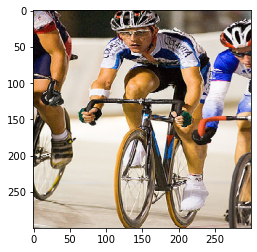

In [135]:
image = Image.open(images_path + "2007_000129.jpg")
image = np.array(image)
image = cv2.resize(image, (width, height,), interpolation=cv2.INTER_NEAREST)
plt.imshow(image)

In [136]:
def get_uniques(t):
    t1d = tf.reshape(t, shape=(-1,))
    # or tf.unique, if you don't need counts
    uniques, idx, counts = tf.unique_with_counts(t1d) 
    return uniques, tf.reshape(idx, shape=tf.shape(t)), counts

annotation = Image.open(segmentation_path + "2007_000129.png")
annotation = np.array(annotation)
annotation[annotation > 20] = 0
annotation = cv2.resize(annotation, (width, height,), interpolation=cv2.INTER_NEAREST)
uniques, _, _ = get_uniques(annotation)
for el in uniques:
    print(el.numpy(), labels_to_name[el.numpy()])

0 background
15 person
2 bicycle


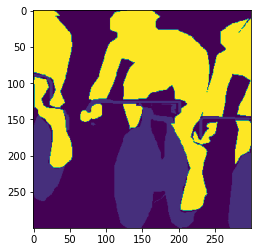

In [137]:
plt.imshow(annotation)